#Hierarchical Attention Networks

##Mounting Google drive space

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

DATA_PATH = 'gdrive/My Drive/ADBI CAPSTONE PROJECT DELIVERABLES/Dataset/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Import required libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import nltk
import os
import re
import pickle

from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from collections import defaultdict

from keras import layers, regularizers, optimizers, initializers
from keras import backend as K

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.layers import Activation, LSTM, GRU, Bidirectional, TimeDistributed, CuDNNLSTM
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from keras.engine.topology import Layer, InputSpec



import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import GridSearchCV


plt.switch_backend('agg')
%matplotlib inline

##Initializing constants

In [0]:
MAX_SENT_LENGTH = 100
MAX_SENTS = 15
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.2

##Extracting data to dataframe

In [0]:
# Setting the data to the contents of the dataset
data = DATA_PATH + 'yelp.csv'

# Reading data file contents to sample using pandas library
sample = pd.read_csv(data)

# Cleaning data - dropping NA values
sample = sample.dropna()

# Resetting index position
sample = sample.reset_index(drop=True)
print('Shape of dataset ',sample.shape)
print(sample.columns)
print('No. of unique classes',len(set(sample['stars'])))

Shape of dataset  (10000, 10)
Index(['business_id', 'date', 'review_id', 'stars', 'text', 'type', 'user_id',
       'cool', 'useful', 'funny'],
      dtype='object')
No. of unique classes 5


## Displaying some details about the dataset

In [0]:
print('Shape of dataset :',sample.shape)
print('Data columns :', sample.columns)
print('No. of unique types :',len(set(sample.type)))
print('No. of unique stars :',len(set(sample.stars)))
print('No. of unique texts :',len(set(sample.text)))
print('Data for top 5 rows :', sample.head())
sample.describe(include='all')

Shape of dataset : (10000, 10)
Data columns : Index(['business_id', 'date', 'review_id', 'stars', 'text', 'type', 'user_id',
       'cool', 'useful', 'funny'],
      dtype='object')
No. of unique types : 1
No. of unique stars : 5
No. of unique texts : 9998
Data for top 5 rows :               business_id        date               review_id  stars  \
0  9yKzy9PApeiPPOUJEtnvkg  2011-01-26  fWKvX83p0-ka4JS3dc6E5A      5   
1  ZRJwVLyzEJq1VAihDhYiow  2011-07-27  IjZ33sJrzXqU-0X6U8NwyA      5   
2  6oRAC4uyJCsJl1X0WZpVSA  2012-06-14  IESLBzqUCLdSzSqm0eCSxQ      4   
3  _1QQZuf4zZOyFCvXc0o6Vg  2010-05-27  G-WvGaISbqqaMHlNnByodA      5   
4  6ozycU1RpktNG2-1BroVtw  2012-01-05  1uJFq2r5QfJG_6ExMRCaGw      5   

                                                text    type  \
0  My wife took me here on my birthday for breakf...  review   
1  I have no idea why some people give bad review...  review   
2  love the gyro plate. Rice is so good and I als...  review   
3  Rosie, Dakota, and I LOVE Cha

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
count,10000,10000,10000,10000.000000,10000,10000,10000,10000.000000,10000.000000,10000.000000
unique,4174,1995,10000,NaN,9998,1,6403,NaN,NaN,NaN
top,JokKtdXU7zXHcr20Lrk29A,2011-03-28,fzo5Lb_t9xaMRBHFagzItA,NaN,This review is for the chain in general. The l...,review,fczQCSmaWF78toLEmb0Zsw,NaN,NaN,NaN
freq,37,21,1,NaN,2,10000,38,NaN,NaN,NaN
mean,NaN,NaN,NaN,3.777500,NaN,NaN,NaN,0.876800,1.409300,0.701300
std,NaN,NaN,NaN,1.214636,NaN,NaN,NaN,2.067861,2.336647,1.907942
min,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,0.000000,1.000000,0.000000
75%,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,1.000000,2.000000,1.000000


##Preprocessing to improve dataset

In [0]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

##Import required libraries

In [0]:
import nltk
from nltk import tokenize

reviews = []
labels = []
texts = []

In [0]:
macronum=sorted(set(sample.stars))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

sample.stars=sample.stars.apply(fun)

In [0]:
for i in range(sample.text.shape[0]):
    text = BeautifulSoup(sample.text[i])
    text=clean_str(str(text.get_text().encode()).lower())
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)


for i in sample['stars']:
    labels.append(i)

## Tokenization  and getting the count of unique tokens

In [0]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

data = np.zeros((len(texts), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')

for i, sentences in enumerate(reviews):
    for j, sent in enumerate(sentences):
        if j< MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                if k<MAX_SENT_LENGTH and tokenizer.word_index[word]<MAX_NB_WORDS:
                    data[i,j,k] = tokenizer.word_index[word]
                    k=k+1

In [0]:
word_index = tokenizer.word_index
print('No. of %s unique tokens.' % len(word_index))

No. of 34151 unique tokens.


## Splitting the dataset into training, testing and validation sets

In [0]:
nb_test_samples = int(TEST_SPLIT* data.shape[0])


In [0]:
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)


data = data[:-nb_test_samples]
labels = labels[:-nb_test_samples]
x_test = data[-nb_test_samples:]
y_test = labels[-nb_test_samples:]


indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

Shape of data tensor: (10000, 15, 100)
Shape of label tensor: (10000, 5)


In [0]:
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = x_train[-nb_validation_samples:]
y_val = y_train[-nb_validation_samples:]

## Importing the glove dataset

In [0]:
glove_data = DATA_PATH + 'glove.6B.100d.txt'
embeddings_index = {}
f = open(glove_data,encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


## Creating the embedding matrix

In [0]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SENT_LENGTH,
                            trainable=True)

## Creating the model

In [0]:
def create_model(learning_rate=0.01):

  sentence_input = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
  embedded_sequences = embedding_layer(sentence_input)
  l_lstm = Bidirectional(CuDNNLSTM(100))(embedded_sequences)
  sentEncoder = Model(sentence_input, l_lstm)

  review_input = Input(shape=(MAX_SENTS,MAX_SENT_LENGTH), dtype='int32')
  review_encoder = TimeDistributed(sentEncoder)(review_input)
  l_lstm_sent = Bidirectional(CuDNNLSTM(100))(review_encoder)
  preds = Dense(len(macronum), activation='softmax',activity_regularizer=regularizers.l1(0.00001))(l_lstm_sent)
  rmsprop = optimizers.RMSprop(lr=learning_rate)
  model = Model(review_input, preds)

  model.compile(loss='categorical_crossentropy',
                optimizer=rmsprop,
                metrics=['acc'])

  print("Hierachical LSTM")
  print(model.summary())
  return model

In [0]:
create_model()

Hierachical LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 15, 100)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 200)           3576800   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200)               241600    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1005      
Total params: 3,819,405
Trainable params: 3,819,405
Non-trainable params: 0
_________________________________________________________________
None


## Hyperparameter tuning

In [0]:
model = KerasClassifier(build_fn=create_model, verbose=1)

#epochs = [10, 15, 20]
batch_size = [64, 128, 256]
learning_rate = [0.001, 0.0001, 0.00001]

param_grid = dict(batch_size=batch_size, learning_rate=learning_rate)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=2)
grid_result = grid.fit(data,labels,epochs=15)

Hierachical LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 15, 100)           0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 15, 200)           3576800   
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 200)               241600    
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 1005      
Total params: 3,819,405
Trainable params: 3,819,405
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
4000/4000 [==============================] - 6s 2ms/step - loss: 1.4058 - acc: 0.3783
Epoch 2/15
4000/4000 [==============================] - 4s 1ms/step - loss: 1.1277 - acc: 0.4982
Epoch 3/15
4000/4000 [==========================

## Printing the best model

In [0]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.697875 using {'batch_size': 256, 'learning_rate': 0.001}
0.610875 (0.026625) with: {'batch_size': 64, 'learning_rate': 0.001}
0.623875 (0.008625) with: {'batch_size': 64, 'learning_rate': 0.0001}
0.401375 (0.008875) with: {'batch_size': 64, 'learning_rate': 1e-05}
0.587000 (0.081250) with: {'batch_size': 128, 'learning_rate': 0.001}
0.638875 (0.005625) with: {'batch_size': 128, 'learning_rate': 0.0001}
0.392500 (0.003250) with: {'batch_size': 128, 'learning_rate': 1e-05}
0.697875 (0.002375) with: {'batch_size': 256, 'learning_rate': 0.001}
0.640875 (0.025125) with: {'batch_size': 256, 'learning_rate': 0.0001}
0.375250 (0.005500) with: {'batch_size': 256, 'learning_rate': 1e-05}


In [0]:
import keras as keras
import time
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [0]:
best_batch_size= 256 
best_epochs = 15
best_learning_rate= 0.001

best_model = create_model(best_learning_rate)
#cp=ModelCheckpoint('model_han_.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
time_callback = TimeHistory()
history=best_model.fit(x_train, y_train, validation_data=(x_val, y_val), callbacks=[time_callback],epochs=best_epochs, batch_size=best_batch_size)
times = time_callback.times

Hierachical LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_62 (InputLayer)        (None, 15, 100)           0         
_________________________________________________________________
time_distributed_31 (TimeDis (None, 15, 200)           3576800   
_________________________________________________________________
bidirectional_62 (Bidirectio (None, 200)               241600    
_________________________________________________________________
dense_31 (Dense)             (None, 5)                 1005      
Total params: 3,819,405
Trainable params: 3,819,405
Non-trainable params: 0
_________________________________________________________________
None
Train on 6400 samples, validate on 1600 samples
Epoch 1/15
6400/6400 [==============================] - 15s 2ms/step - loss: 1.4274 - acc: 0.3778 - val_loss: 1.2022 - val_acc: 0.5356
Epoch 2/15
6400/6400 [==============================] - 7s 

## Saving the best model

In [0]:
best_model.save_weights('gdrive/My Drive/ADBI CAPSTONE PROJECT DELIVERABLES/Results/Models/Best_HAN_model_2.h5')

## Plotting the loss curves

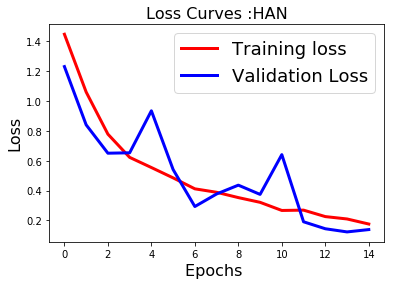

In [0]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :HAN',fontsize=16)
fig1.savefig('gdrive/My Drive/ADBI CAPSTONE PROJECT DELIVERABLES/Results/best_model_loss_han_2.png')
plt.show()

## Plotting the accuracy curves

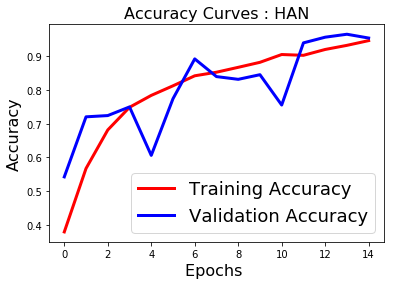

In [0]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : HAN',fontsize=16)
fig2.savefig('gdrive/My Drive/ADBI CAPSTONE PROJECT DELIVERABLES/Results/best_model_accuracy_han_2.png')
plt.show()

## Calculating the accuracy of the testing dataset

In [0]:
score = best_model.evaluate(x_test, y_test,
                       batch_size=256, verbose=1)
 
print('Test accuracy:', score[1])

2000/2000 [==============================] - 1s 328us/step
Test accuracy: 0.9355000023841857
